# Calibration of a diffraction setup using `Jupyter` notebooks

This notebook presents a very simple GUI for doing the calibration of diffraction setup within the `Jupyter-Lab` or `Jupyter-Notebook` environment with `Matplotlib` and `Ipywidgets`. 
It has been tested with `widget` and the `notebook` (aka `nbagg`) integration of matplotlib.
It requires also `matplotlib.inline`

Despite this is in the `cookbook` section, this **tutorial** requires advanced Python programming knowledge and some good understanding of `PyFAI`.

This tutorial is also available as a video:

In [1]:
#Video of this tutorial
#Skip to 7:55 in you already know jupyter notebook and you are just interested in the calibration.
from IPython.display import Video

Video("http://www.silx.org/pub/pyFAI/video/Calibration_Jupyter.mp4", width=800)


The basic idea is to port directly the original `pyFAI-calib` tool which was done with `matplotlib` into the Jupyter notebooks. Most credits go **Philipp Hans** for the adaptation of the origin PeakPicker class to Jupyter.

The PeakPicker widget has been refactored and the Calibration tool adapted for the notebook usage.
Several external tools were used with the following version:

In [2]:
for lib in ["jupyterlab", "notebook", "matplotlib", "matplotlib_inline", "ipympl", "ipywidgets"]:
    mod = __import__(lib)
    print(f"{lib:18s}:   {mod.__version__}")

jupyterlab        :   4.4.10
notebook          :   7.4.7
matplotlib        :   3.10.8
matplotlib_inline :   0.2.1
ipympl            :   0.9.8
ipywidgets        :   8.1.8


In [3]:
# The notebook interface (nbagg) is needed in jupyter-notebook while the widget is recommended for jupyer lab
# %matplotlib nbagg 
# %matplotlib widget
# For the integration in the documentation, one uses `inline` to capture figures.
# %matplotlib inline

import json
import pyFAI
import pyFAI.test.utilstest
import fabio
from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration

print(f"PyFAI version {pyFAI.version}")

PyFAI version 2025.11.0-dev0


In [4]:
# Some parameters like the wavelength, the calibrant and the diffraction image:
wavelength = 1e-10
pilatus = pyFAI.detector_factory("Pilatus1M")
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength = wavelength

#load some test data (requires an internet connection)
img = fabio.open(pyFAI.test.utilstest.UtilsTest.getimage("Pilatus1M.edf")).data

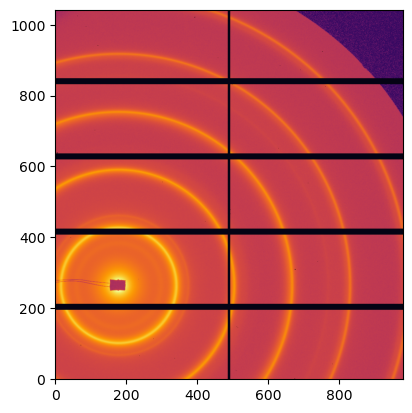

In [5]:
%matplotlib inline
# Simply display the scattering image:
jupyter.display(img);

In [6]:
%matplotlib widget
calib = Calibration(img, calibrant=AgBh, wavelength=wavelength, detector=pilatus)
# This displays the calibration widget: 

# 1. Set the ring number (0-based value), below the plot 
# 2. Pick the ring by right-clicking with the mouse on the image.
# 3. Restart at 1. for at least a second ring
# 4. Click refine to launch the calibration.

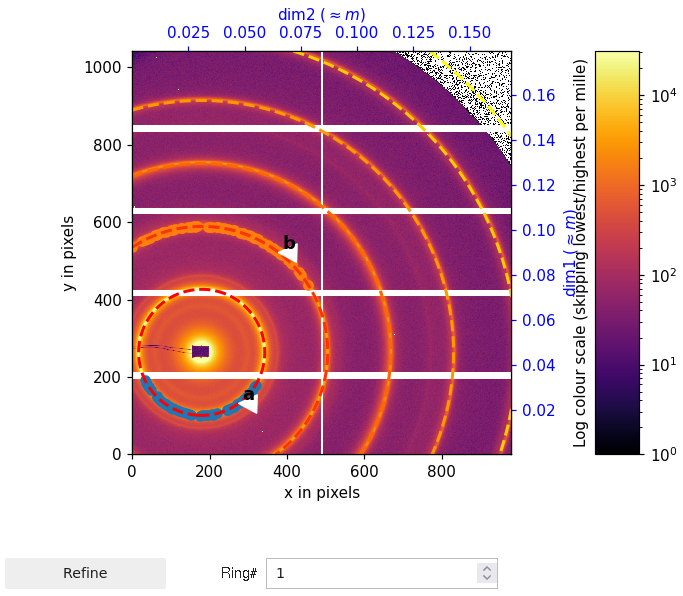

In [7]:
# Here is a screenshot of the previous widget, since it is not recoreded inside the notebook itself.
from IPython.display import Image
Image(filename='pyFAI-calib_notebook.png') 

In [11]:
# This is the calibrated geometry:
gr = calib.geoRef
print(gr)
print(f"{calib.fixed}")
print(f"Cost function: {gr.chi2()}")

Detector Pilatus 1M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.000000 Å
SampleDetDist= 1.634651e+00 m	PONI= 4.163022e-02, 2.491802e-02 m	rot1=-0.003675  rot2=0.002319  rot3=0.000000 rad
DirectBeamDist= 1634.667 mm	Center: x=179.795, y=264.075 pix	Tilt= 0.249° tiltPlanRotation= 32.255° λ= 1.000Å
Fixed parameters: rot3, wavelength.
Cost function: 2.2839442064415372e-07


In [12]:
# re-extract all control points using the "massif" algorithm 
calib.extract_cpt()

In [13]:
# remove the last ring since it is outside the flight-tube
calib.remove_grp(lbl="f")

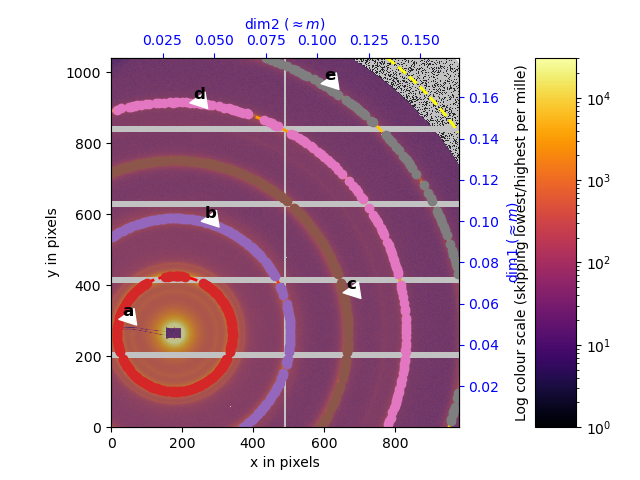

In [14]:
# Switch back to `inline` mode to capture the last plot
%matplotlib inline
calib.peakPicker.widget.fig.show()

In [15]:
#Those are some control points: the last column indicates the ring number
calib.geoRef.data[::100]

array([[304.0095607 ,  21.69750673,   0.        ],
       [399.72302023, 267.97505114,   0.        ],
       [130.67039672,  84.91515963,   0.        ],
       [315.05417652, 501.06431608,   1.        ],
       [368.09403084, 656.46089101,   2.        ],
       [ 28.27949998, 608.21160227,   2.        ],
       [266.01534331, 831.35403025,   3.        ],
       [ 48.11429094, 966.3203724 ,   4.        ]])

In [17]:
# This is the geometry with all rings defined:
gr = calib.geoRef
print(gr)
print(f"{calib.fixed}")
print(f"Cost function: {gr.chi2()}")

Detector Pilatus 1M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.000000 Å
SampleDetDist= 1.634651e+00 m	PONI= 4.163022e-02, 2.491802e-02 m	rot1=-0.003675  rot2=0.002319  rot3=0.000000 rad
DirectBeamDist= 1634.667 mm	Center: x=179.795, y=264.075 pix	Tilt= 0.249° tiltPlanRotation= 32.255° λ= 1.000Å
Fixed parameters: rot3, wavelength.
Cost function: 9.036029434362592e-07


In [ ]:
# Geometry refinement with some constrains: SAXS mode 
# Here we enforce all rotation to be null and fit again the model:

gr.rot1 = gr.rot2 = gr.rot3 = 0
gr.refine3(fix=["rot1", "rot2", "rot3", "wavelength"])
print(gr)
print(f"Cost function = {gr.chi2()}")

In [ ]:
gr.save("jupyter.poni")
print(json.dumps(gr.get_config(), indent=2))

In [ ]:
# Create a "normal" azimuthal integrator (without fitting capabilities from the geometry-refinement object)
ai = pyFAI.load(gr)
ai

In [ ]:
# Display the integrated data to validate the calibration.
fig, ax = subplots(1, 2, figsize=(10, 5))
jupyter.plot1d(ai.integrate1d(img, 1000),  calibrant=AgBh, ax=ax[0])
jupyter.plot2d(ai.integrate2d(img, 1000),  calibrant=AgBh, ax=ax[1])
ax[1].set_title("2D integration");

## Conclusion

This short notebook shows how to interact with a calibration image to pick some control-point from the Debye-Scherrer ring and to perform the calibration of the experimental setup.